In [1]:
from IPython import display
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.sparse.linalg
import math
import time

# The Algorithm, Phase added

**1 -** Solve for $\rho$ (charge density) via $\rho = \sum_\alpha n_\alpha \, q_\alpha$

<br>

**2 -** Solve for $\phi$ (electric potential) via solving $\nabla E = \frac{e^2}{\epsilon_0} \, \rho$ and $\nabla \phi = - \frac{E}{\epsilon_r}$ by substitution: 

&emsp;&emsp; $ \nabla^2 \phi = - \frac{1}{\epsilon_r} \nabla E \implies \nabla^2 \phi = - \frac{e^2}{\epsilon_0 \epsilon_r} \, \rho $

<br>

**3 -** For each $\alpha$ do:

&emsp;&emsp; **a )** Let $\bar{\mu}_\alpha^S \equiv \bar{\mu}_\alpha(\theta = 0)$ and $\bar{\mu}_\alpha^L \equiv \bar{\mu}_\alpha(\theta = 1)$. For $A_\alpha \in \mathbb{R}, \, f(\theta) := \theta^2 \, (1 - \theta)^2, \, h(\theta) := 3 \theta^2 - 2 \theta^3 = \theta^2 (3 - 2 \theta) $, the update becomes:  

&emsp;&emsp;&emsp;&emsp; $\bar{\mu}_\alpha = \bar{\mu}_\alpha^S + \left(\bar{\mu}_\alpha^L - \bar{\mu}_\alpha^S \right) h(\theta) + \frac{1}{2} A_\alpha \, f(\theta) + \frac{1}{2} \epsilon^2 |\nabla \theta|^2 $

<br>

&emsp;&emsp; **b )** Take the $\theta$ time-step via 

&emsp;&emsp;&emsp;&emsp;$\frac{\partial}{\partial t} \theta \approx M V_{cell} \sum_\alpha n_\alpha \left[ \left(\bar{\mu}_\alpha^L - \bar{\mu}_\alpha^S \right) \frac{\partial}{\partial \theta} h(\theta) - A_\alpha \frac{\partial}{\partial \theta} f(\theta) + \epsilon^2 \nabla^2 \theta \right] $  

&emsp;&emsp;&emsp;&emsp; $\theta^{k+1} = \theta^{k} + \Delta t \left( \frac{\partial}{\partial t} \theta \right)^k $ 

&emsp;&emsp;&emsp;&emsp; where $\frac{\partial}{\partial \theta} f(\theta) := 2 \theta (1 - \theta) (1 - 2 \theta)$ and $\frac{\partial}{\partial \theta} h(\theta) := 6 \theta (1 - \theta) $



<br>


&emsp;&emsp; **c )** $\mu_\alpha = \bar{\mu}_\alpha + q_\alpha \, \phi$

<br>

&emsp;&emsp; **d )** $v_\alpha = \frac{1}{a} D_\alpha$

<br>

&emsp;&emsp; **e )** Create the `J_alpha_UMat` via the cellular update framework implemented to streamline and replace the $J_\alpha$ and the $\frac{\partial}{\partial t} n_\alpha$ calculations

<br>

&emsp;&emsp; **f )** Take the $n_\alpha$ time-step via $n_\alpha^{k+1} = n_\alpha^k + \frac{\Delta t}{a}$ `J_alpha_UMat`


<br>




In [15]:
def laplace_matrix_3D_RD(Nx, Ny, Nz):
    """
    Creates the 3D Laplacian discretization matrix for a rectangular domain,
        thereby allowing for cases where Nx =/= Ny 
    Input: Nx & Ny & Nz (int), number of grid points on x- & y- & z-axes
    
    ORRRRRR ????? 
    
    Input: Nx, Ny, Nz (int), number of grid points in each respective direction
    
    Output: A_matrix (float array), 3D Laplacian discretization matrix
    """
    
    # initialize the 3D Poisson discretization matrix
    A_matrix = np.zeros((Nx*Ny*Nz, Nx*Ny*Nz))
    
    # add the diagonal entries corresponding to the top and bottom neighbors (of the cells on the main diagonal) respectively
    A_matrix += np.diag(np.ones(Nx * Ny * Nz - Nx), -Nx) + np.diag(np.ones(Nx * Ny * Nz - Nx), Nx) 
    
    # Below, essentially iterate over main diagonal rather than  all entries (cuts computational cost by ~ a square root)
    for i in range(Nx*Ny*Nz): 
        
        # add the main diagonal entries corresponding to the "current" cells
            # all other entries on the same row represent these cells' respective neighborhoods
        A_matrix[i][i] = -6
        
        # add the diagonal entries corresponding to the right neighbors 
        if (i > 0):
            A_matrix[i-1][i] = 1

        # checks if "current" cell is at the end of a row
        if (((i + 1) % Nx == 1) and (i < Nx * Ny * Nz - 1)): 
            
            # "current" cell does NOT have a right neighbor
            A_matrix[i-1][i] = 0

        # add the diagonal entries corresponding to the left neighbors    
        if (i > 0):
            
            A_matrix[i][i-1] = 1

        # checks if "current" cell is at the beginning of a row    
        if (((i + 1) % Nx == 1) and (i > 2)):
            
            # "current" cell does NOT have a left neighbor
            A_matrix[i][i-1] = 0
            
        # checks if "current" cell is at the beginning of a z-layer (depth) 
        if (((i + 1) % (Nx*Ny) == 0) and (i < Nx * Ny * Nz - Nx)):
            
            # reset i (to remove non-existent top and bottom neighbors, all assumed to exist at the beginning)
            i -= Nx-1

            # will use to remove Nx top and Nx bottom neighbors            
            cntr = 0
            
            while (cntr < Nx):
                
                A_matrix[i+cntr+Nx][i+cntr] = 0 # "current" cell does NOT have a top neighbor
                A_matrix[i+cntr][i+cntr+Nx] = 0 # "current" cell does NOT have a bottom neighbor
                
                cntr += 1
            
            # set i back to pre-while loop value
            i += Nx-1

    # add the diagonal entries corresponding to the front and back neighbors (of the cells on the main diagonal) respectively       
    A_matrix += np.diag(np.ones(Nx * Ny * Nz - Nx * Ny), -Nx*Ny) + np.diag(np.ones(Nx * Ny * Nz - Nx * Ny), Nx*Ny)
    
    return A_matrix

***Step 1 :*** $\rho$ Update

In [16]:
def rho_update_3D(n_alpha, q_alpha):
    """
    Updates / computes rho^k (rho at the current time-step)
    Input: n_alpha (float array), (alpha) x (Nx) x (Ny) x (Nz) array storing 
               current n_alpha grid values for each respective species alpha
           q_alpha (int array), each entry represents charge of a species
    Output: rho (float array), (Nx) x (Ny) x (Nz) charge density array
    """
    # initialize rho to Nx x Ny x Nz size, bypass the 1st array dimension
    rho = np.zeros(np.shape(n_alpha)[1:]) 
    
    # iterate over the alphas
    for i in range(np.shape(n_alpha)[0]):
        
        rho += n_alpha[i] * q_alpha[i]
        
    return rho # return 3D rho array

*Changes :* Removed the `Na` input.

***Step 2 :*** $\phi$ Update

In [245]:
def phi_update_3D(a, Nx, Ny, Nz, A_matrix, rho, epsilon_0 = 1, epsilon_r = 1): 
    """
    Updates / computes phi^k (phi at the current time-step) via
        solving Poisson's equation
    Input: a (float), a = dx = dy = dz
           Nx & Ny & Nz (int), number of grid points on x- & y- & z-axes
           A_matrix (float array), 3D Laplacian discretization matrix
           rho (float array), (Nx) x (Ny) x (Nz) charge density array
           epsilon_0 & epsilon_r (float), constants
    Output: phi (float array), (Nx) x (Ny) x (Nz) electric potential array
    """
    
    c_rho = a**2 * np.exp(1)**2 / (2.0 * epsilon_0 * epsilon_r) # store the constant for the RHS vector
        
    rho_vec = rho.flatten() # from 3D to 1D
        
    # use GMRES to solve for phi^k (until you explore solver efficiency!!!!)
    phi = scipy.sparse.linalg.gmres(-A_matrix, c_rho * rho_vec)[0]
    
    return phi.reshape((Nx, Ny, Nz)) # return 3D phi array
    

*Changes :* `ghosts_included = True` input removed since the Poisson discretization matrix we are using assumes that the ghost cells lying outside of the computational domain have Dirichlet BCs (of 0s). Therefore also removed the removal and addition of ghost cells within the computational domain.

`Na` input changed to `Nx, Ny, Nz` to allow for rectangular domains. Also added `a`. 

***Step 3 - a :*** $\bar{\mu}_\alpha$ Update



In [200]:
def gradient_finder_3D(func):
    """
    Finds the d/dx, d/dy and d/dz gradient fields of a 3D function/matrix
    NOTE : Identical to what numpy.gradient() does, however serves as
        a proof of concept for the C++ implementation
    NOTE : numpy.hstack() & .vstack() used for convenience, would be 
        replaced by simple loops in C++
    Inputs: func (float array), (Nx) x (Ny) array with entries representing function
        values for which d/dx and d/dy will be calculated
    Output: dx_func & dy_func (float array), (Nx) x (Ny) dfunc/dx & dfunc/dy arrays    
    """
    (Nx, Ny, Nz) = np.shape(func)
    
    # calculate the x-derivative
        # cells in the middle have the average of the left- and right- derivatives
    x_difference = func[1:, :, :]  - func[:-1, :, :] # defined as x_i+1,j,k - x_i,j,k
    dx_func = np.vstack((np.array([x_difference[0,:,:]]), 0.5 * (x_difference[1:,:,:] + x_difference[:-1,:,:]), np.array([x_difference[-1,:,:]])))
    
    # calculate the y-derivative
        # cells in the middle have the average of the down- and up- derivatives
    y_difference = func[:, 1:, :] - func[:, :-1, :] # defined as x_i,j+1,k - x_i,j,k
    y_i = np.zeros((Nx, 1, Nz))
    y_f = np.zeros((Nx, 1, Nz))
    for i in range(Nx):
        y_i[i] = np.array([y_difference[:,0,:]])[:,i]
        y_f[i] = np.array([y_difference[:,-1,:]])[:,i]
    dy_func = np.hstack((y_i, 0.5 * (y_difference[:,1:,:] + y_difference[:,:-1,:]), y_f))
    
    # calculate the z-derivative
        # cells in the middle have the average of the front- and back- derivatives
    z_difference = func[:, :, 1:] - func[:, :, :-1] # defined as x_i,j,k+1 - x_i,j,k
    z_i = z_difference[:,:,0].reshape((Nx, Ny, 1))
    z_f = z_difference[:,:,-1].reshape((Nx, Ny, 1))
    dz_func = np.dstack((z_i, 0.5 * (z_difference[:,:,1:] + z_difference[:,:,:-1]), z_f))
    
    return dx_func, dy_func, dz_func # return 3D dfunc/dx & dfunc/dy arrays 

In [206]:
# random example
ex = np.random.rand(5,3,5)

dex_1, dey_1, dez_1 = gradient_finder_3D(ex)
dex, dey, dez = np.gradient(ex)

print('Error:')
print(np.sum(np.abs(dex_1 - dex)))
print(np.sum(np.abs(dey_1 - dey)))
print(np.sum(np.abs(dez_1 - dez)))
print('\nEquality?')
print(np.allclose(dex_1, dex))
print(np.allclose(dey_1, dey))
print(np.allclose(dez_1, dez))


Error:
0.0
0.0
0.0

Equality?
True
True
True


In [256]:
def mu_bar_alpha_update_3D(a, Nx, Ny, Nz, theta, mu_bar_alpha_0, mu_bar_alpha_1, A_alpha, epsilon): 
    """
    Updates / computes mu_bar_alpha^k (mu_bar_alpha at the current time-step)
    Input: a (float), a = dx = dy = dz
           Nx & Ny & Nz (int), number of grid points on x- & y- & z-axes
           theta (float array), (Nx * Ny * Nz) array representing the flattened 3D phase
           mu_bar_alpha_0 & mu_bar_alpha_1 (float array), (alpha) x (Nx * Ny * Nz) mu_bar_alpha
               chemical potential arrays for the purely solid and liquid phases respectively
           A_alpha (float array), each entry represents a constant for a species
           epsilon (float), a constant scaling theta's gradient contribution 
    Output: mu_bar_alpha (float array), (alpha) x (Nx) x (Ny) x (Nz) electrochemical potential array
    """
    mu_bar_alpha = np.zeros(np.shape(mu_bar_alpha_0)) # initialize mu_bar_alpha as a 3D alpha x Nx*Ny*Nz array
    
    # store the f(theta) expression
    f_theta = theta**2 * (1 - theta)**2
    
    # store the h(theta) expression
    h_theta = theta**2 * (3 - 2 * theta)
   
    # store the gradient of theta expression (independent of alpha)
                        #dthet_dx, dthet_dy = np.gradient(0.5 * epsilon**2 * theta.reshape([Nx, Ny]))
    dtheta_dx, dtheta_dy, dtheta_dz = gradient_finder_3D(0.5 * epsilon**2 * theta.reshape([Nx, Ny, Nz]))
    
    for i in range(np.shape(mu_bar_alpha_0)[0]): # iterate over the alphas
        
        # update / compute mu_bar_alpha
        mu_bar_alpha[i] = mu_bar_alpha_0[i] + (mu_bar_alpha_1[i] - mu_bar_alpha_0[i]) * h_theta.flatten() - 0.5 * A_alpha[i] * f_theta.flatten() + 0.5 * epsilon**2 * (dtheta_dx.flatten()**2 + dtheta_dy.flatten()**2 + dtheta_dz.flatten()**2) 
        
    return mu_bar_alpha.reshape((np.shape(mu_bar_alpha_0)[0], Nx, Ny, Nz)) # return as a 4D alpha x Nx x Ny x Nz array
                                                                        # for easier use in mu_alpha_update()
    

***Step 3 - b :*** $\theta$ Update / Time-Step

&emsp;&emsp;&emsp;&emsp;$\frac{\partial}{\partial t} \theta \approx M V_{cell} \sum_\alpha n_\alpha \left[ \left(\bar{\mu}_\alpha^L - \bar{\mu}_\alpha^S \right) \frac{\partial}{\partial \theta} h(\theta) - A_\alpha \frac{\partial}{\partial \theta} f(\theta) + \epsilon^2 \nabla^2 \theta \right] $  

&emsp;&emsp;&emsp;&emsp; $\theta^{k+1} = \theta^{k} + \Delta t \left( \frac{\partial}{\partial t} \theta \right)^k $ 

&emsp;&emsp;&emsp;&emsp; where $\frac{\partial}{\partial \theta} f(\theta) := 2 \theta (1 - \theta) (1 - 2 \theta)$ and $\frac{\partial}{\partial \theta} h(\theta) := 6 \theta (1 - \theta) $





In [257]:
def theta_update_3D(dt, a, Nx, Ny, Nz, n_alpha, theta, A_matrix, A_alpha, mu_bar_alpha_0, mu_bar_alpha_1, M, epsilon):
    """
    Updates / computes theta^(k+1) (theta at the future time-step) via 
        forward in time discretization
    Input: dt (float), size of time-step, dt
           a (float), a = dx = dy = dz
           Nx & Ny & Nz (int), number of grid points on x- & y- & z-axes
           n_alpha (float array), (alpha) x (Nx) x (Ny) x (Nz) array storing current n_alpha
               grid values for each respective species alpha
           theta^k (float array), (Nx * Ny * Nz) array representing the flattened 3D phase
           A_matrix (float array), 3D Laplacian discretization matrix
           A_alpha (float array), each entry represents a constant for a species
           mu_bar_alpha_0 & mu_bar_alpha_1 (float array), (alpha) x (Nx * Ny* Nz) mu_bar_alpha
               arrays for the purely solid and liquid phases respectively
           M (float), a constant 
           epsilon (float), a constant scaling theta's Laplacian contribution 
    Output: theta^(k+1) (float array), (Nx * Ny * Nz) array representing the flattened 3D phase
    """
    # initialize dtheta/dt
    dtheta_dt = np.zeros(np.shape(theta))
    
    # calculate & store h'(theta) and f'(theta)
    df_dt = theta * (1 - theta) * (1 - 2 * theta)
    dh_dt = 6 * theta * (1 - theta)
    
    # save the result of the matrix-vector product 
    A_theta = A_matrix @ theta
    A_theta = np.pad((A_theta.reshape([Nx,Ny,Nz])[1:-1,1:-1,1:-1]), 1)
    
    # Neumann BCs (the looping is identical to that explained in J_alpha_update_3D()!)
    # deal with Surface BCs
    for i in range(1, np.shape(n_alpha)[1] - 1):
        for j in range(1, np.shape(n_alpha)[2] - 1):
            # top surface BC
            k = 0 
            A_theta[i,j,k] = A_theta[i,j,k+1] 
            # bottom surface BC
            k = np.shape(n_alpha)[3] - 1 
            A_theta[i,j,k] = A_theta[i,j,k-1]
    for i in range(1, np.shape(n_alpha)[1] - 1):
        for k in range(1, np.shape(n_alpha)[3] - 1):
            # front surface BC
            j = 0 
            A_theta[i,j,k] = A_theta[i,j+1,k] 
            # back surface BC
            j = np.shape(n_alpha)[2] - 1 
            A_theta[i,j,k] = A_theta[i,j-1,k]
    for j in range(1, np.shape(n_alpha)[2] - 1):
        for k in range(1, np.shape(n_alpha)[3] - 1):
            # left surface BC
            i = 0 
            A_theta[i,j,k] = A_theta[i+1,j,k] 
            # right surface BC
            i = np.shape(n_alpha)[1] - 1 
            A_theta[i,j,k] = A_theta[i-1,j,k]
    # deal with Edge BCs
    for i in range(1, np.shape(n_alpha)[1] - 1):
        # bottom back BC
        (j, k) = (0, 0)
        A_theta[i,j,k] = 0.5 * (A_theta[i,j+1,k] + A_theta[i,j,k+1])
        # bottom front BC
        (j, k) = (np.shape(n_alpha)[2] - 1, 0)
        A_theta[i,j,k] = 0.5 * (A_theta[i,j-1,k] + A_theta[i,j,k+1])
        # top back BC
        (j, k) = (0, np.shape(n_alpha)[3] - 1)
        A_theta[i,j,k] = 0.5 * (A_theta[i,j+1,k] + A_theta[i,j,k-1])
        # top front BC
        (j, k) = (np.shape(n_alpha)[2] - 1, np.shape(n_alpha)[3] - 1)
        A_theta[i,j,k] = 0.5 * (A_theta[i,j-1,k] + A_theta[i,j,k-1])
    for j in range(1, np.shape(n_alpha)[2] - 1):
         # left bottom BC
        (i, k) = (0, 0)
        A_theta[i,j,k] = 0.5 * (A_theta[i+1,j,k] + A_theta[i,j,k+1])
        # right bottom
        (i, k) = (np.shape(n_alpha)[1] - 1, 0)
        A_theta[i,j,k] = 0.5 * (A_theta[i-1,j,k] + A_theta[i,j,k+1])
        # left top
        (i, k) = (0, np.shape(n_alpha)[3] - 1)
        A_theta[i,j,k] = 0.5 * (A_theta[i+1,j,k] + A_theta[i,j,k-1])
        # right top
        (i, k) = (np.shape(n_alpha)[1] - 1, np.shape(n_alpha)[3] - 1)
        A_theta[i,j,k] = 0.5 * (A_theta[i-1,j,k] + A_theta[i,j,k-1])
    for k in range(1, np.shape(n_alpha)[3] - 1):
         # left back BC
        (i, j) = (0, 0)
        A_theta[i,j,k] = 0.5 * (A_theta[i+1,j,k] + A_theta[i,j+1,k])
        # right back BC
        (i, j) = (np.shape(n_alpha)[1] - 1, 0)
        A_theta[i,j,k] = 0.5 * (A_theta[i-1,j,k] + A_theta[i,j+1,k])
        # left front BC
        (i, j) = (0, np.shape(n_alpha)[2] - 1)
        A_theta[i,j,k] = 0.5 * (A_theta[i+1,j,k] + A_theta[i,j-1,k])
        # right front BC
        (i, j) = (np.shape(n_alpha)[1] - 1, np.shape(n_alpha)[2] - 1)
        A_theta[i,j,k] = 0.5 * (A_theta[i-1,j,k] + A_theta[i,j-1,k])
    # deal with Corner BCs (8 corners in total)
    (i, j, k) = (0, 0, 0)
    A_theta[i,j,k] = (A_theta[i+1,j,k] + A_theta[i,j+1,k] + A_theta[i,j,k+1])/3
    (i, j, k) = (np.shape(n_alpha)[1] - 1, 0, 0)
    A_theta[i,j,k] = (A_theta[i-1,j,k] + A_theta[i,j+1,k] + A_theta[i,j,k+1])/3
    (i, j, k) = (0, np.shape(n_alpha)[2] - 1, 0)
    A_theta[i,j,k] = (A_theta[i+1,j,k] + A_theta[i,j-1,k] + A_theta[i,j,k+1])/3
    (i, j, k) = (0, 0, np.shape(n_alpha)[3] - 1)
    A_theta[i,j,k] = (A_theta[i+1,j,k] + A_theta[i,j+1,k] + A_theta[i,j,k-1])/3
    (i, j, k) = (np.shape(n_alpha)[1] - 1, np.shape(n_alpha)[2] - 1, 0)
    A_theta[i,j,k] = (A_theta[i-1,j,k] + A_theta[i,j-1,k] + A_theta[i,j,k+1])/3
    (i, j, k) = (np.shape(n_alpha)[1] - 1, 0, np.shape(n_alpha)[3] - 1)
    A_theta[i,j,k] = (A_theta[i-1,j,k] + A_theta[i,j+1,k] + A_theta[i,j,k-1])/3
    (i, j, k) = (0, np.shape(n_alpha)[2] - 1, np.shape(n_alpha)[3] - 1)
    A_theta[i,j,k] = (A_theta[i+1,j,k] + A_theta[i,j-1,k] + A_theta[i,j,k-1])/3
    (i, j, k) = (np.shape(n_alpha)[1] - 1, np.shape(n_alpha)[2] - 1, np.shape(n_alpha)[3] - 1)
    A_theta[i,j,k] = (A_theta[i-1,j,k] + A_theta[i,j-1,k] + A_theta[i,j,k-1])/3        
    
    # from 2D to 1D storage
    A_theta = A_theta.flatten() 
        
    # sum over the alphas
    for i in range(np.shape(mu_bar_alpha_0)[0]):
        
        dtheta_dt += n_alpha[i].flatten() * ((mu_bar_alpha_1[i] - mu_bar_alpha_0[i]) * dh_dt - A_alpha[i] * df_dt + epsilon**2 * A_theta)
        
    # take a theta time-step
    theta += dt * M * dtheta_dt
    
    return theta

In [220]:
exx = np.random.rand(3,3,3)

exx = np.pad(exx, 1)

exx

array([[[0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.27659035, 0.10939314, 0.07367523, 0.        ],
        [0.        , 0.51810768, 0.47366843, 0.22358066, 0.        ],
        [0.        , 0.64430177, 0.59291712, 0.59680376, 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.74933522, 0.61624568, 0.35994355, 0.        ],
        [0.        , 0.8298194 , 0.21300614, 0.85488266, 0.        ],
        [0.        , 0.19916922, 0.05353283, 0.39556511, 0.        ],
        [0.     

***Step 3 - c & d :*** ${\mu}_\alpha \& v_\alpha$ Update

In [221]:
def mu_and_v_alpha_update_3D(a, T, k_B, mu_bar_alpha, q_alpha, phi, D_alpha):
    """
    Input: a (float), a = dx = dy = dz
           mu_bar_alpha (float array), (alpha) x (Nx) x (Ny) x (Nz) chemical potential array
           q_alpha (int array), each entry represents charge of a species
           phi (float array), (Nx) x (Ny) x (Nz) electric potential array
           D_alpha (float array), (alpha) x (Nx) x (Ny) x (Nz) diffusion coefficient array
    Output: mu_alpha (float array), (alpha) x (Nx) x (Ny) x (Nz) electrochemical potential array
            v_alpha (float array), (alpha) x (Nx) x (Ny) x (Nz) velocity array
    """
    # initialize mu_alpha
    mu_alpha = np.zeros(np.shape(mu_bar_alpha))

    # initialize v_alpha
    v_alpha = np.zeros(np.shape(mu_bar_alpha))
    
     # NOTE : we want to store the exponential expression relating mu_alpha to J_alpha
        # to minimize computational cost by minimizing the np.exp() calls. This will 
        # become evident in the J_alpha_update_3D() function.

    c = 2 * k_B * T # store constant
    
    for i in range(len(q_alpha)): # loop over 1st dimension (layer) of 4D mu_alpha & v_alpha tensors
        
        # equivalent to mu_alpha = np.exp(mu_alpha/c)                                 
        mu_alpha[i] = np.exp((mu_bar_alpha[i] + q_alpha[i] * phi)/c)  

        v_alpha[i] = (1.0/a) * D_alpha[i]
          
    return mu_alpha, v_alpha # both returned as 4D alpha x Nx x Ny x Nz arrays


***Step 3 - e :*** $J_\alpha$ "Update" via `J_alpha_UMat`

In [222]:
def J_alpha_update_3D(mu_alpha, v_alpha, n_alpha):
    """
    Computes the precursor to dn_alpha/dt, J_alpha_UMat
    Input: mu_alpha (float array), (alpha) x (Nx) x (Ny) x (Nz) electrochemical potential array 
           v_alpha (float array), (alpha) x (Nx) x (Ny) x (Nz) velocity array
           n_alpha (float array), (alpha) x (Nx) x (Ny) x (Nz) array storing current n_alpha
               grid values for each respective species alpha
    Output: J_alpha_UMat (float array), (alpha) x (Nx) x (Ny) x (Nz) particle current update array
    """
    # initialize J_alpha_UMat to have m x (Nx) x (Ny) x (Nz) dimensions
    J_alpha_UMat = np.zeros((np.shape(n_alpha)[0], np.shape(n_alpha)[1], np.shape(n_alpha)[2], np.shape(n_alpha)[3]))
    # Our update matrix which we will simply scale and then add on n_alpha_Current !!! Pretty COOL !
    
    # Our axes : +-----> (x-axis)
    #           /|
    #          / |
    #(z-axis) v  v (y-axis)
    # each cell n_alpha has 6 possible neighbors, left, right, top, bottom, front, back
        # all of these neighbors exchange information to form dn/dt
        # NOTE: some cells have 3 (corner) or 4 (edge) or 5 (surface) neighbors which needs to be accounted for
                #(any cube domain has 8 corner cells, 12 * (Na - 2) edge cells, 
                # and 6 * (Na - 2)^2 surface cells, and of course this can be generalized for
                # rectangular prism domains)
    # now iterate over each grid index, update J_alpha_UMat values for all alphas each iteration
    
    # 1st : Deal with the Interior (Nx - 2) x (Ny - 2) x (Nz - 2) domain
    for i in range(1, np.shape(n_alpha)[1] - 1):
        for j in range(1, np.shape(n_alpha)[2] - 1):
            for k in range(1, np.shape(n_alpha)[3] - 1):
            
                # signs given to be positive if flow into cell i,j
                J_left = v_alpha[:,i-1,j,k] * n_alpha[:,i-1,j,k] * mu_alpha[:,i-1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i-1,j,k]
                J_right = v_alpha[:,i+1,j,k] * n_alpha[:,i+1,j,k] * mu_alpha[:,i+1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i+1,j,k]
                J_top = v_alpha[:,i,j-1,k] * n_alpha[:,i,j-1,k] * mu_alpha[:,i,j-1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j-1,k]
                J_bottom = v_alpha[:,i,j+1,k] * n_alpha[:,i,j+1,k] * mu_alpha[:,i,j+1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j+1,k]
                J_front = v_alpha[:,i,j,k-1] * n_alpha[:,i,j,k-1] * mu_alpha[:,i,j,k-1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k-1]
                J_back = v_alpha[:,i,j,k+1] * n_alpha[:,i,j,k+1] * mu_alpha[:,i,j,k+1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k+1]
            
                J_alpha_UMat[:,i,j,k] = J_left + J_right + J_top + J_bottom + J_front + J_back
    
    
    # 2nd : Deal with the Surfaces
    for i in range(1, np.shape(n_alpha)[1] - 1):
        for j in range(1, np.shape(n_alpha)[2] - 1):
            
            # top surface
            k = 0
            J_left = v_alpha[:,i-1,j,k] * n_alpha[:,i-1,j,k] * mu_alpha[:,i-1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i-1,j,k]
            J_right = v_alpha[:,i+1,j,k] * n_alpha[:,i+1,j,k] * mu_alpha[:,i+1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i+1,j,k]
            J_top = v_alpha[:,i,j-1,k] * n_alpha[:,i,j-1,k] * mu_alpha[:,i,j-1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j-1,k]
            J_bottom = v_alpha[:,i,j+1,k] * n_alpha[:,i,j+1,k] * mu_alpha[:,i,j+1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j+1,k]
            J_back = v_alpha[:,i,j,k+1] * n_alpha[:,i,j,k+1] * mu_alpha[:,i,j,k+1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k+1]
            
            J_alpha_UMat[:,i,j,k] = J_left + J_right + J_top + J_bottom + J_back
    
            # bottom surface
            k = np.shape(n_alpha)[3] - 1
            J_left = v_alpha[:,i-1,j,k] * n_alpha[:,i-1,j,k] * mu_alpha[:,i-1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i-1,j,k]
            J_right = v_alpha[:,i+1,j,k] * n_alpha[:,i+1,j,k] * mu_alpha[:,i+1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i+1,j,k]
            J_top = v_alpha[:,i,j-1,k] * n_alpha[:,i,j-1,k] * mu_alpha[:,i,j-1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j-1,k]
            J_bottom = v_alpha[:,i,j+1,k] * n_alpha[:,i,j+1,k] * mu_alpha[:,i,j+1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j+1,k]
            J_front = v_alpha[:,i,j,k-1] * n_alpha[:,i,j,k-1] * mu_alpha[:,i,j,k-1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k-1]
            
            J_alpha_UMat[:,i,j,k] = J_left + J_right + J_top + J_bottom + J_front 
    
    for i in range(1, np.shape(n_alpha)[1] - 1):
        for k in range(1, np.shape(n_alpha)[3] - 1):
            
            # front surface
            j = 0
            J_left = v_alpha[:,i-1,j,k] * n_alpha[:,i-1,j,k] * mu_alpha[:,i-1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i-1,j,k]
            J_right = v_alpha[:,i+1,j,k] * n_alpha[:,i+1,j,k] * mu_alpha[:,i+1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i+1,j,k]
            J_bottom = v_alpha[:,i,j+1,k] * n_alpha[:,i,j+1,k] * mu_alpha[:,i,j+1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j+1,k]
            J_front = v_alpha[:,i,j,k-1] * n_alpha[:,i,j,k-1] * mu_alpha[:,i,j,k-1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k-1]
            J_back = v_alpha[:,i,j,k+1] * n_alpha[:,i,j,k+1] * mu_alpha[:,i,j,k+1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k+1]
            
            J_alpha_UMat[:,i,j,k] = J_left + J_right + J_bottom + J_front + J_back
    
            # back surface
            j = np.shape(n_alpha)[2] - 1
            J_left = v_alpha[:,i-1,j,k] * n_alpha[:,i-1,j,k] * mu_alpha[:,i-1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i-1,j,k]
            J_right = v_alpha[:,i+1,j,k] * n_alpha[:,i+1,j,k] * mu_alpha[:,i+1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i+1,j,k]
            J_top = v_alpha[:,i,j-1,k] * n_alpha[:,i,j-1,k] * mu_alpha[:,i,j-1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j-1,k]
            J_front = v_alpha[:,i,j,k-1] * n_alpha[:,i,j,k-1] * mu_alpha[:,i,j,k-1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k-1]
            J_back = v_alpha[:,i,j,k+1] * n_alpha[:,i,j,k+1] * mu_alpha[:,i,j,k+1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k+1]
            
            J_alpha_UMat[:,i,j,k] = J_left + J_right + J_top + J_front + J_back
    
    for j in range(1, np.shape(n_alpha)[2] - 1):
        for k in range(1, np.shape(n_alpha)[3] - 1):
            
            # left surface
            i = 0
            J_right = v_alpha[:,i+1,j,k] * n_alpha[:,i+1,j,k] * mu_alpha[:,i+1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i+1,j,k]
            J_top = v_alpha[:,i,j-1,k] * n_alpha[:,i,j-1,k] * mu_alpha[:,i,j-1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j-1,k]
            J_bottom = v_alpha[:,i,j+1,k] * n_alpha[:,i,j+1,k] * mu_alpha[:,i,j+1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j+1,k]
            J_front = v_alpha[:,i,j,k-1] * n_alpha[:,i,j,k-1] * mu_alpha[:,i,j,k-1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k-1]
            J_back = v_alpha[:,i,j,k+1] * n_alpha[:,i,j,k+1] * mu_alpha[:,i,j,k+1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k+1]
            
            J_alpha_UMat[:,i,j,k] = J_right + J_top + J_bottom + J_front + J_back
    
            # right surface
            i = np.shape(n_alpha)[1] - 1
            J_left = v_alpha[:,i-1,j,k] * n_alpha[:,i-1,j,k] * mu_alpha[:,i-1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i-1,j,k]
            J_top = v_alpha[:,i,j-1,k] * n_alpha[:,i,j-1,k] * mu_alpha[:,i,j-1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j-1,k]
            J_bottom = v_alpha[:,i,j+1,k] * n_alpha[:,i,j+1,k] * mu_alpha[:,i,j+1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j+1,k]
            J_front = v_alpha[:,i,j,k-1] * n_alpha[:,i,j,k-1] * mu_alpha[:,i,j,k-1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k-1]
            J_back = v_alpha[:,i,j,k+1] * n_alpha[:,i,j,k+1] * mu_alpha[:,i,j,k+1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k+1]
            
            J_alpha_UMat[:,i,j,k] = J_left + J_top + J_bottom + J_front + J_back
    
    
    # 3rd : Deal with the Edges
        # NOTE : each edge corresponds to fixing two of the i,j,k indices and varying the other
        # varing i,j,k respectively should yield 4 edges per index, so 3*4 = 12
    for i in range(1, np.shape(n_alpha)[1] - 1):
        
        # bottom back 
        j = 0
        k = 0
        J_left = v_alpha[:,i-1,j,k] * n_alpha[:,i-1,j,k] * mu_alpha[:,i-1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i-1,j,k]
        J_right = v_alpha[:,i+1,j,k] * n_alpha[:,i+1,j,k] * mu_alpha[:,i+1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i+1,j,k]
        J_bottom = v_alpha[:,i,j+1,k] * n_alpha[:,i,j+1,k] * mu_alpha[:,i,j+1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j+1,k]
        J_back = v_alpha[:,i,j,k+1] * n_alpha[:,i,j,k+1] * mu_alpha[:,i,j,k+1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k+1]
            
        J_alpha_UMat[:,i,j,k] = J_left + J_right + J_bottom + J_back
    
        # bottom front
        j = np.shape(n_alpha)[2] - 1
        k = 0
        J_left = v_alpha[:,i-1,j,k] * n_alpha[:,i-1,j,k] * mu_alpha[:,i-1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i-1,j,k]
        J_right = v_alpha[:,i+1,j,k] * n_alpha[:,i+1,j,k] * mu_alpha[:,i+1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i+1,j,k]
        J_top = v_alpha[:,i,j-1,k] * n_alpha[:,i,j-1,k] * mu_alpha[:,i,j-1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j-1,k]
        J_back = v_alpha[:,i,j,k+1] * n_alpha[:,i,j,k+1] * mu_alpha[:,i,j,k+1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k+1]
            
        J_alpha_UMat[:,i,j,k] = J_left + J_right + J_top + J_back
        
        # top back
        j = 0
        k = np.shape(n_alpha)[3] - 1
        J_left = v_alpha[:,i-1,j,k] * n_alpha[:,i-1,j,k] * mu_alpha[:,i-1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i-1,j,k]
        J_right = v_alpha[:,i+1,j,k] * n_alpha[:,i+1,j,k] * mu_alpha[:,i+1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i+1,j,k]
        J_bottom = v_alpha[:,i,j+1,k] * n_alpha[:,i,j+1,k] * mu_alpha[:,i,j+1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j+1,k]
        J_front = v_alpha[:,i,j,k-1] * n_alpha[:,i,j,k-1] * mu_alpha[:,i,j,k-1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k-1]
        
        J_alpha_UMat[:,i,j,k] = J_left + J_right + J_bottom + J_front
        
        # top front
        j = np.shape(n_alpha)[2] - 1
        k = np.shape(n_alpha)[3] - 1
        J_left = v_alpha[:,i-1,j,k] * n_alpha[:,i-1,j,k] * mu_alpha[:,i-1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i-1,j,k]
        J_right = v_alpha[:,i+1,j,k] * n_alpha[:,i+1,j,k] * mu_alpha[:,i+1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i+1,j,k]
        J_top = v_alpha[:,i,j-1,k] * n_alpha[:,i,j-1,k] * mu_alpha[:,i,j-1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j-1,k]
        J_front = v_alpha[:,i,j,k-1] * n_alpha[:,i,j,k-1] * mu_alpha[:,i,j,k-1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k-1]
            
        J_alpha_UMat[:,i,j,k] = J_left + J_right + J_top + J_front
        
    for j in range(1, np.shape(n_alpha)[2] - 1):
        
        # left bottom
        i = 0
        k = 0
        J_right = v_alpha[:,i+1,j,k] * n_alpha[:,i+1,j,k] * mu_alpha[:,i+1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i+1,j,k]
        J_top = v_alpha[:,i,j-1,k] * n_alpha[:,i,j-1,k] * mu_alpha[:,i,j-1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j-1,k]
        J_bottom = v_alpha[:,i,j+1,k] * n_alpha[:,i,j+1,k] * mu_alpha[:,i,j+1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j+1,k]
        J_back = v_alpha[:,i,j,k+1] * n_alpha[:,i,j,k+1] * mu_alpha[:,i,j,k+1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k+1]
            
        J_alpha_UMat[:,i,j,k] = J_right + J_top + J_bottom + J_back
        
        # right bottom
        i = np.shape(n_alpha)[1] - 1
        k = 0
        J_left = v_alpha[:,i-1,j,k] * n_alpha[:,i-1,j,k] * mu_alpha[:,i-1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i-1,j,k]
        J_top = v_alpha[:,i,j-1,k] * n_alpha[:,i,j-1,k] * mu_alpha[:,i,j-1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j-1,k]
        J_bottom = v_alpha[:,i,j+1,k] * n_alpha[:,i,j+1,k] * mu_alpha[:,i,j+1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j+1,k]
        J_back = v_alpha[:,i,j,k+1] * n_alpha[:,i,j,k+1] * mu_alpha[:,i,j,k+1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k+1]
            
        J_alpha_UMat[:,i,j,k] = J_left + J_top + J_bottom + J_back
        
        # left top
        i = 0
        k = np.shape(n_alpha)[3] - 1
        J_right = v_alpha[:,i+1,j,k] * n_alpha[:,i+1,j,k] * mu_alpha[:,i+1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i+1,j,k]
        J_top = v_alpha[:,i,j-1,k] * n_alpha[:,i,j-1,k] * mu_alpha[:,i,j-1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j-1,k]
        J_bottom = v_alpha[:,i,j+1,k] * n_alpha[:,i,j+1,k] * mu_alpha[:,i,j+1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j+1,k]
        J_front = v_alpha[:,i,j,k-1] * n_alpha[:,i,j,k-1] * mu_alpha[:,i,j,k-1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k-1]
            
        J_alpha_UMat[:,i,j,k] = J_right + J_top + J_bottom + J_front
        
        # right top
        i = np.shape(n_alpha)[1] - 1
        k = np.shape(n_alpha)[3] - 1
        J_left = v_alpha[:,i-1,j,k] * n_alpha[:,i-1,j,k] * mu_alpha[:,i-1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i-1,j,k]
        J_top = v_alpha[:,i,j-1,k] * n_alpha[:,i,j-1,k] * mu_alpha[:,i,j-1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j-1,k]
        J_bottom = v_alpha[:,i,j+1,k] * n_alpha[:,i,j+1,k] * mu_alpha[:,i,j+1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j+1,k]
        J_front = v_alpha[:,i,j,k-1] * n_alpha[:,i,j,k-1] * mu_alpha[:,i,j,k-1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k-1]
            
        J_alpha_UMat[:,i,j,k] = J_left + J_top + J_bottom + J_front
        
    for k in range(1, np.shape(n_alpha)[3] - 1):
        
        # left back
        i = 0
        j = 0
        J_right = v_alpha[:,i+1,j,k] * n_alpha[:,i+1,j,k] * mu_alpha[:,i+1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i+1,j,k]
        J_bottom = v_alpha[:,i,j+1,k] * n_alpha[:,i,j+1,k] * mu_alpha[:,i,j+1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j+1,k]
        J_front = v_alpha[:,i,j,k-1] * n_alpha[:,i,j,k-1] * mu_alpha[:,i,j,k-1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k-1]
        J_back = v_alpha[:,i,j,k+1] * n_alpha[:,i,j,k+1] * mu_alpha[:,i,j,k+1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k+1]
            
        J_alpha_UMat[:,i,j,k] = J_right + J_bottom + J_front + J_back
        
        # right back
        i = np.shape(n_alpha)[1] - 1
        j = 0
        J_left = v_alpha[:,i-1,j,k] * n_alpha[:,i-1,j,k] * mu_alpha[:,i-1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i-1,j,k]
        J_bottom = v_alpha[:,i,j+1,k] * n_alpha[:,i,j+1,k] * mu_alpha[:,i,j+1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j+1,k]
        J_front = v_alpha[:,i,j,k-1] * n_alpha[:,i,j,k-1] * mu_alpha[:,i,j,k-1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k-1]
        J_back = v_alpha[:,i,j,k+1] * n_alpha[:,i,j,k+1] * mu_alpha[:,i,j,k+1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k+1]
            
        J_alpha_UMat[:,i,j,k] = J_left + J_bottom + J_front + J_back
        
        # left front
        i = 0
        j = np.shape(n_alpha)[2] - 1
        J_right = v_alpha[:,i+1,j,k] * n_alpha[:,i+1,j,k] * mu_alpha[:,i+1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i+1,j,k]
        J_top = v_alpha[:,i,j-1,k] * n_alpha[:,i,j-1,k] * mu_alpha[:,i,j-1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j-1,k]
        J_front = v_alpha[:,i,j,k-1] * n_alpha[:,i,j,k-1] * mu_alpha[:,i,j,k-1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k-1]
        J_back = v_alpha[:,i,j,k+1] * n_alpha[:,i,j,k+1] * mu_alpha[:,i,j,k+1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k+1]
            
        J_alpha_UMat[:,i,j,k] = J_right + J_top + J_front + J_back
        
        # right front
        i = np.shape(n_alpha)[1] - 1
        j = np.shape(n_alpha)[2] - 1
        J_left = v_alpha[:,i-1,j,k] * n_alpha[:,i-1,j,k] * mu_alpha[:,i-1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i-1,j,k]
        J_top = v_alpha[:,i,j-1,k] * n_alpha[:,i,j-1,k] * mu_alpha[:,i,j-1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j-1,k]
        J_front = v_alpha[:,i,j,k-1] * n_alpha[:,i,j,k-1] * mu_alpha[:,i,j,k-1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k-1]
        J_back = v_alpha[:,i,j,k+1] * n_alpha[:,i,j,k+1] * mu_alpha[:,i,j,k+1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k+1]
            
        J_alpha_UMat[:,i,j,k] = J_left + J_top + J_front + J_back
         
        
    # 4th : Deal with the Corners
        # NOTE : we have 2 possible values for each of i,j,k, yielding 2^3 = 8 corners
    # for corner at (0, 0, 0)
    i = 0
    j = 0
    k = 0
    J_right = v_alpha[:,i+1,j,k] * n_alpha[:,i+1,j,k] * mu_alpha[:,i+1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i+1,j,k]
    J_bottom = v_alpha[:,i,j+1,k] * n_alpha[:,i,j+1,k] * mu_alpha[:,i,j+1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j+1,k]
    J_back = v_alpha[:,i,j,k+1] * n_alpha[:,i,j,k+1] * mu_alpha[:,i,j,k+1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k+1]   
    J_alpha_UMat[:,i,j,k] = J_right + J_bottom + J_back
    
    # for corner at (0, 0, Nz)
    i = 0
    j = 0
    k = np.shape(n_alpha)[3] - 1
    J_right = v_alpha[:,i+1,j,k] * n_alpha[:,i+1,j,k] * mu_alpha[:,i+1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i+1,j,k]
    J_bottom = v_alpha[:,i,j+1,k] * n_alpha[:,i,j+1,k] * mu_alpha[:,i,j+1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j+1,k]
    J_front = v_alpha[:,i,j,k-1] * n_alpha[:,i,j,k-1] * mu_alpha[:,i,j,k-1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k-1]   
    J_alpha_UMat[:,i,j,k] = J_right + J_top + J_bottom + J_front
    
    # for corner at (0, Ny, 0)
    i = 0
    j = np.shape(n_alpha)[2] - 1
    k = 0
    J_right = v_alpha[:,i+1,j,k] * n_alpha[:,i+1,j,k] * mu_alpha[:,i+1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i+1,j,k]
    J_top = v_alpha[:,i,j-1,k] * n_alpha[:,i,j-1,k] * mu_alpha[:,i,j-1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j-1,k]
    J_back = v_alpha[:,i,j,k+1] * n_alpha[:,i,j,k+1] * mu_alpha[:,i,j,k+1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k+1]      
    J_alpha_UMat[:,i,j,k] = J_right + J_top + J_back
    
    # for corner at (Nx, 0, 0)
    i = np.shape(n_alpha)[1] - 1
    j = 0
    k = 0
    J_left = v_alpha[:,i-1,j,k] * n_alpha[:,i-1,j,k] * mu_alpha[:,i-1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i-1,j,k]
    J_bottom = v_alpha[:,i,j+1,k] * n_alpha[:,i,j+1,k] * mu_alpha[:,i,j+1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j+1,k]
    J_back = v_alpha[:,i,j,k+1] * n_alpha[:,i,j,k+1] * mu_alpha[:,i,j,k+1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k+1]
    J_alpha_UMat[:,i,j,k] = J_left + J_bottom + J_back
    
    # for corner at (Nx, Ny, 0)
    i = np.shape(n_alpha)[1] - 1
    j = np.shape(n_alpha)[2] - 1
    k = 0
    J_left = v_alpha[:,i-1,j,k] * n_alpha[:,i-1,j,k] * mu_alpha[:,i-1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i-1,j,k]
    J_top = v_alpha[:,i,j-1,k] * n_alpha[:,i,j-1,k] * mu_alpha[:,i,j-1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j-1,k]
    J_back = v_alpha[:,i,j,k+1] * n_alpha[:,i,j,k+1] * mu_alpha[:,i,j,k+1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k+1]
    J_alpha_UMat[:,i,j,k] = J_left + J_top + J_back
    
    # for corner at (0, Ny, Nz)
    i = 0
    j = np.shape(n_alpha)[2] - 1
    k = np.shape(n_alpha)[3] - 1
    J_right = v_alpha[:,i+1,j,k] * n_alpha[:,i+1,j,k] * mu_alpha[:,i+1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i+1,j,k]
    J_top = v_alpha[:,i,j-1,k] * n_alpha[:,i,j-1,k] * mu_alpha[:,i,j-1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j-1,k]
    J_front = v_alpha[:,i,j,k-1] * n_alpha[:,i,j,k-1] * mu_alpha[:,i,j,k-1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k-1]     
    J_alpha_UMat[:,i,j,k] = J_right + J_top + J_front 
    
    # for corner at (Nx, 0, Nz)
    i = np.shape(n_alpha)[1] - 1
    j = 0
    k = np.shape(n_alpha)[3] - 1
    J_left = v_alpha[:,i-1,j,k] * n_alpha[:,i-1,j,k] * mu_alpha[:,i-1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i-1,j,k]
    J_bottom = v_alpha[:,i,j+1,k] * n_alpha[:,i,j+1,k] * mu_alpha[:,i,j+1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j+1,k]
    J_front = v_alpha[:,i,j,k-1] * n_alpha[:,i,j,k-1] * mu_alpha[:,i,j,k-1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k-1]      
    J_alpha_UMat[:,i,j,k] = J_left + J_bottom + J_front
    
    # for corner at (Nx, Ny, Nz)
    i = np.shape(n_alpha)[1] - 1
    j = np.shape(n_alpha)[2] - 1
    k = np.shape(n_alpha)[3] - 1
    J_left = v_alpha[:,i-1,j,k] * n_alpha[:,i-1,j,k] * mu_alpha[:,i-1,j,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i-1,j,k]
    J_top = v_alpha[:,i,j-1,k] * n_alpha[:,i,j-1,k] * mu_alpha[:,i,j-1,k] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j-1,k]
    J_front = v_alpha[:,i,j,k-1] * n_alpha[:,i,j,k-1] * mu_alpha[:,i,j,k-1] / mu_alpha[:,i,j,k] - v_alpha[:,i,j,k] * n_alpha[:,i,j,k] * mu_alpha[:,i,j,k] / mu_alpha[:,i,j,k-1]      
    J_alpha_UMat[:,i,j,k] = J_left + J_top + J_front
    
    return J_alpha_UMat




***Step 3 - f :*** $n_\alpha$ Update / Time-Step

In [223]:
def n_alpha_update_Forward_3D(dt, a, n_alpha, J_alpha_UMat):
    """
    Updates / computes n_alpha^(k+1) (n_alpha at the future time-step) via 
        forward in time discretization
    Input: dt (float), size of time-step, dt
           a (float), a = dx = dy
           n_alpha (float array), (alpha) x (Nx) x (Ny) x (Nz) array storing current n_alpha
               grid values for each respective species alpha
           J_alpha_UMat (float array), (alpha) x (Nx) x (Ny) x (Nz) particle current update array
    Output: n_alpha^(k+1) (float array), (alpha) x (Nx) x (Ny) x (Nz) array storing updated n_alpha
               grid values for each respective species alpha
    """
    # take a time-step for n_alpha
    n_alpha += (dt / a) * J_alpha_UMat
    
    return n_alpha

***Iteration Function***

In [260]:
def iteration_Forward_3D(dt, i_glob, a, Nx, Ny, Nz, T, k_B, A_matrix, q_alpha, theta, n_alpha, mu_bar_alpha_0, mu_bar_alpha_1, D_alpha, A_alpha, M, epsilon, epsilon_0 = 1, epsilon_r = 1):
    """
    Performs an iteration via forward in time discretization
    Input: dt (float), size of time-step, dt
           i_glob (int), global iteration counter (UNUSED VARIABLE)
           a (float), a = dx = dy = dz
           Nx & Ny & Nz (int), number of grid points on x- & y- & z-axes
           T (float), temperature
           k_B (float), Boltzmann's constant 
           A_matrix (float array), 3D Laplacian discretization matrix
           q_alpha (int array), each entry represents charge of a species
           theta (float array), (Nx * Ny * Nz) array representing the flattened 3D phase
           n_alpha (float array), (alpha) x (Nx) x (Ny) x (Nz) array storing current n_alpha
               grid values for each respective species alpha
           mu_bar_alpha_0 & mu_bar_alpha_1 (float array), (alpha) x (Nx * Ny * Nz) mu_bar_alpha
               chemical potential arrays for the purely solid and liquid phases respectively
           D_alpha (float array), (alpha) x (Nx) x (Ny) x (Nz) diffusion coefficient array
           A_alpha (float array), each entry represents a constant for a species
           M & epsilon & epsilon_0 & epsilon_r (float), constants
    Output: n_alpha^(k+1) (float array), (alpha) x (Nx) x (Ny) x (Nz) array storing updated n_alpha
               grid values for each respective species alpha
            theta^(k+1) (float array), (Nx * Ny * Nz) array representing the flattened 3D phase
            mu_alpha (float array), (alpha) x (Nx) x (Ny) x (Nz) electrochemical potential array
    """
    # update rho
    rho = rho_update_3D(n_alpha, q_alpha)
    
    # update phi
    phi = phi_update_3D(a, Nx, Ny, Nz, A_matrix, rho, epsilon_0, epsilon_r)
    
    # update mu_bar_alpha
    mu_bar_alpha = mu_bar_alpha_update_3D(a, Nx, Ny, Nz, theta, mu_bar_alpha_0, mu_bar_alpha_1, A_alpha, epsilon)
    
    # update theta (phase) - update after calculating mu_bar_alpha with the current theta
    theta = theta_update_3D(dt, a, Nx, Ny, Nz, n_alpha, theta, A_matrix, A_alpha, mu_bar_alpha_0, mu_bar_alpha_1, M, epsilon)
    
    # update mu_alpha & v_alpha, N O T E : combined mu_alpha_update_1D and v_alpha_update_1D into ONE function
    mu_alpha, v_alpha = mu_and_v_alpha_update_3D(a, T, k_B, mu_bar_alpha, q_alpha, phi, D_alpha)
    
    # update J_alpha
    J_alpha_UMat = J_alpha_update_3D(mu_alpha, v_alpha, n_alpha)
    
    # update n_alpha
    n_alpha = n_alpha_update_Forward_3D(dt, a, n_alpha, J_alpha_UMat)
   
    return n_alpha, theta, mu_alpha

***Simulation Function***



In [267]:
def simulation_Forward_3D(dt, tmax, Nx, Ny, Nz, T, k_B, theta, n_alpha, q_alpha, mu_bar_alpha_0, mu_bar_alpha_1, D_alpha, A_alpha, plotting = False, epsilon_r = 1, epsilon_0 = 1, epsilon = 1, M = 0.1e-3): # dt, Na, B_matrix, q_alpha, n_alpha_Update, n_alpha_Current, n_alpha_Past mu_bar_alpha, D_alpha, ghosts_included = True, epsilon_0 = 1, epsilon_r = 1
    
    i_glob = 0 # global iteration counter (specifically for 1st timestep's n'(x, t) calculation)
    t_cur = 0.0  # global time counter
    
    a = 1/Na # calculate dx
    
    A_x = np.arange(0, 1 + 1e-15, a)         # length of Na + 1
    B_x = np.arange(a/2, 1 - a/2 + 1e-15, a) # length of Na
    
    # initialize 
    n_alpha_Update = np.zeros((len(B_x), 1))
    n_plotting = np.array([])
    
    # construct the Poisson 1D discretization matrix B
    A_matrix = laplace_matrix_3D_RD(Nx, Ny, Nz)
    
    # start plotting/animating
    fig = plt.figure() # initialize figure
    axis = plt.axes(xlim =(0, 1), ylim =(-2, 10)) # marking the x-axis and y-axis 
    line, = axis.plot([], [], lw = 3) # initializing a line variable 
    plt.close() # to not have a stray plot
    
    # data which the line will 
    # contain (x, y) 
    def init(): 
        line.set_data([], []) 
        return line, 
    
    def animate(i): 
        x = np.arange(a/2, 1 - a/2 + 1e-15, a) # set the x axis to B_x

        if (i < int(tmax/dt - 1e-15)):
            
            n_plot = n_plot_matrix[i,:] # extract the i^th row for plotting
        
            line.set_data(x, n_plot) 
            
        else:
            
            return line,
      
        return line,
    
    
    while (t_cur < tmax):
        
        n_alpha, theta, mu_alpha = iteration_Forward_3D(dt, i_glob, a, Nx, Ny, Nz, T, k_B, A_matrix, q_alpha, theta, n_alpha, mu_bar_alpha_0, mu_bar_alpha_1, D_alpha, A_alpha, M, epsilon, epsilon_0 = 1, epsilon_r = 1)
        
        if (plotting):
            
            n_plotting = np.append(n_plotting, n_alpha)
                     
        i_glob += 1
        t_cur += dt
        
    if (plotting):
        
        n_plot_matrix = n_plotting.reshape((int(tmax/dt - 1e-15) + 1, len(B_x))) # every row corresponds to N_alpha 
                                                                 # at a different time-step  
        anim = FuncAnimation(fig, animate, init_func = init, frames = 500, interval = 20, blit = True)
        
        #return HTML(anim.to_jshtml())
        
        return anim
    
    else:
        
        print('\nSimulation completed at time', t_cur, '!!!')
        
        return n_alpha, theta.reshape((Nx, Ny, Nz)), mu_alpha, t_cur

# Melting Test

In [317]:
Na = 15
Nx = Na
Ny = 7
Nz = Na
T = 300
k_B = 1e2
a = 1.0/Na
dt = 2 * a**2
t_max = 50 * dt #2000
x_ax = np.arange(a/2, 1 - a/2 + 1e-15, a)
q_alpha = np.array([0, 0]) #np.array([25, -25])
A_alpha = np.array([1,1])
mu_bar_alpha_0 = 1 + np.zeros((2, Nx * Ny * Nz))  # different mu_bar values for the alphas
mu_bar_alpha_1 = 100 + np.zeros((2, Nx * Ny * Nz))  # different mu_bar values for the alphas
D_alpha = 1e-1 * np.ones((2, Nx, Ny, Nz))
                         
# Forward Euler temporal discretization
N_mid = int((Na-1)/2)
theta = np.zeros((Nx, Ny, Nz))
theta[:,:N_mid,:] = 0.0
#theta[:,N_mid:N_mid+4] = np.linspace(0.1,1,4)
theta[:,N_mid:,:] = 1.0
theta = theta.flatten()

#n_alpha[0, Nx-6:Nx-2, N_mid-2:N_mid+2] += 1.0
#n_alpha[1, 2:6, N_mid-2:N_mid+2] += 1.0
#n_CPFM_1D_forward[:,N_mid-2:N_mid+2, N_mid-2:N_mid+2] = 1.0

n_alpha = 0.01 + np.zeros((2, Nx, Ny, Nz))
n_CPFM_1D_forward = 0.01 + np.zeros((2, Nx, Ny, Nz))

n_alpha[N_mid-1:N_mid+2, N_mid-1:N_mid+2, N_mid-1:N_mid+2] = 1.0



In [318]:
n_CPFM_1D_forward, theta, mu_alpha, t_sim_finalized_FE = simulation_Forward_3D(dt, t_max, Nx, Ny, Nz, T, k_B, theta, n_alpha, q_alpha, mu_bar_alpha_0, mu_bar_alpha_1, D_alpha, A_alpha) 




Simulation completed at time 0.4444444444444445 !!!


In [319]:
np.shape(n_CPFM_1D_forward[0,:,:,1])

(15, 7)

(7, 15) (15, 15)


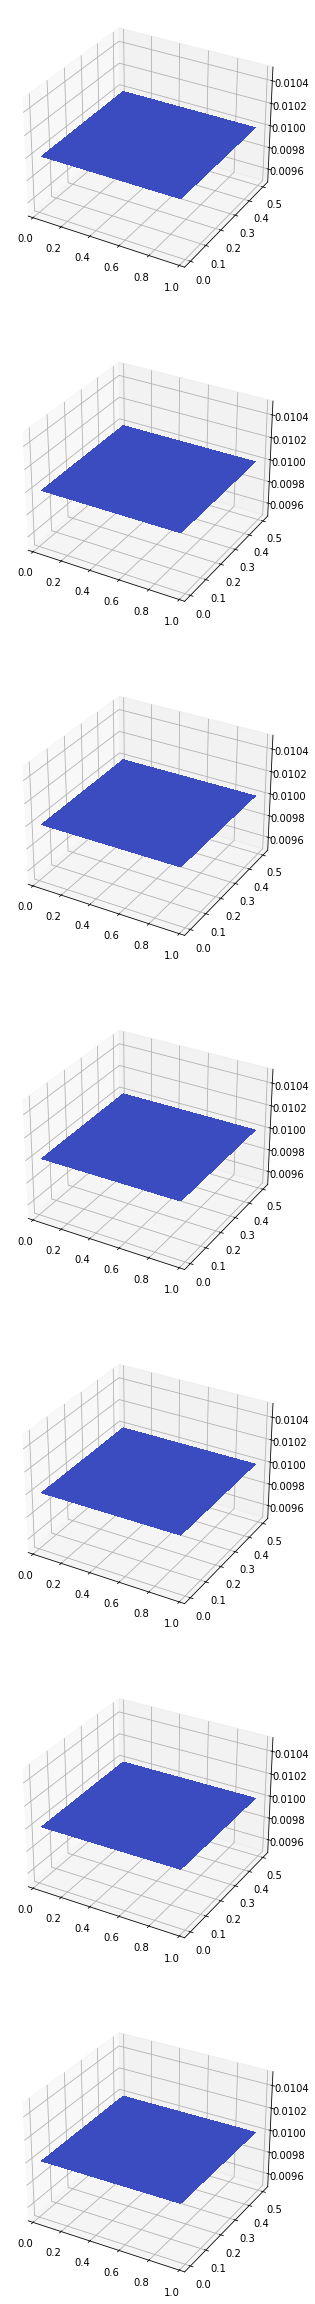

In [320]:
X = x_ax
Y = x_ax

y_ax = np.linspace(0,0.5,7)

xx, ye = np.meshgrid(X, y_ax)

print(np.shape(xx), np.shape(yy))

fig = plt.figure(figsize=(20, 42))

for i in range(np.shape(x_ax)[0]-8):
    
    ax = fig.add_subplot(X.shape[0]-8, 1, i+1, projection='3d')
    ax.plot_surface(xx, ye, np.transpose(n_CPFM_1D_forward[0,:,:,i]), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    
plt.show()     

IndexError: index 7 is out of bounds for axis 2 with size 7

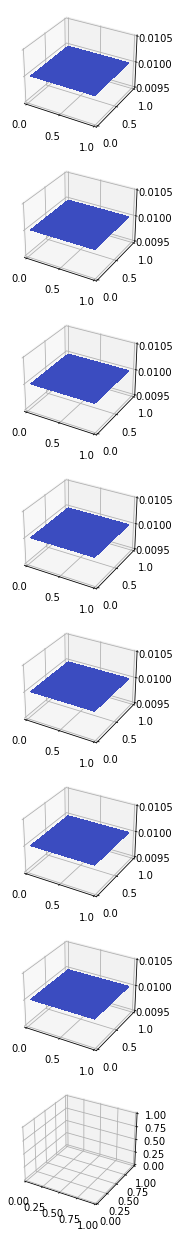

In [321]:
xx, yy = np.meshgrid(X, Y)

fig = plt.figure(figsize=(20, 42))
for i in range(np.shape(x_ax)[0]):
    
    ax = fig.add_subplot(X.shape[0], 1, i+1, projection='3d')
    ax.plot_surface(xx, yy, n_CPFM_1D_forward[0,:,i,:], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    
plt.show()     

In [ ]:
y_ax = np.linspace(0,0.5,7)

xx, ye = np.meshgrid(X, y_ax)

fig = plt.figure(figsize=(20, 42))
for i in range(np.shape(x_ax)[0]):
    
    ax = fig.add_subplot(X.shape[0], 1, i+1, projection='3d')
    ax.plot_surface(xx, ye, n_CPFM_1D_forward[0,i,:,:], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    
plt.show()     